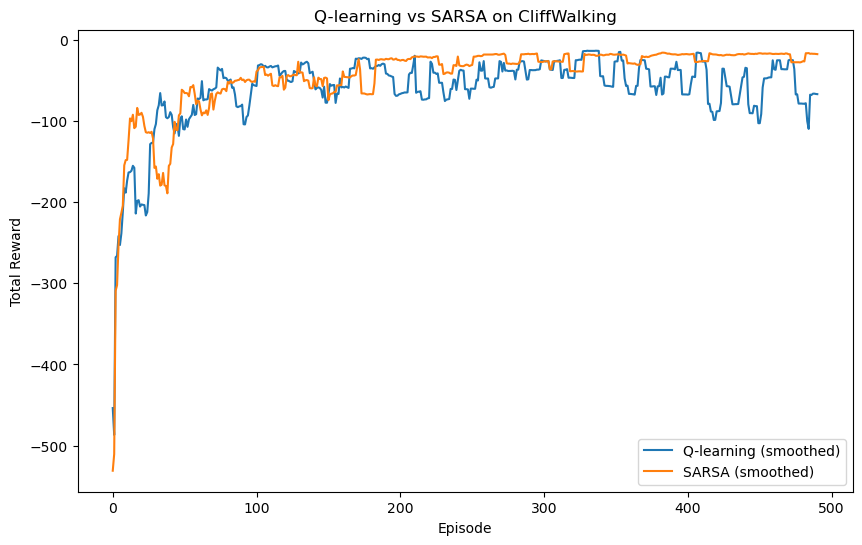

In [7]:
import gym
import numpy as np
import matplotlib.pyplot as plt

def epsilon_greedy_action(state, Q, epsilon):
    """
    Epsilon-greedy strategy for choosing an action given a state and Q-table.
    """
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])  # Random action
    else:
        return np.argmax(Q[state, :])  # Best action

def q_learning(env, alpha=0.1, gamma=1.0, epsilon=0.1, episodes=500):
    """
    Q-learning algorithm for CliffWalking-v0.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    returns_list = []

    for ep in range(episodes):
        reset_output = env.reset()
        state = reset_output[0] if isinstance(reset_output, tuple) else reset_output  # 兼容 Gym/Gymnasium
        done = False
        total_reward = 0
        
        while not done:
            action = epsilon_greedy_action(state, Q, epsilon)
            next_output = env.step(action)
            next_state, reward, done = next_output[:3]  # 兼容 Gym/Gymnasium

            next_state = max(0, min(next_state, Q.shape[0] - 1))  # 防止索引越界
            
            # Q-learning update
            best_next_action = np.argmax(Q[next_state, :])
            td_target = reward + gamma * Q[next_state, best_next_action] * (not done)
            Q[state, action] += alpha * (td_target - Q[state, action])
            
            state = next_state
            total_reward += reward
        
        returns_list.append(total_reward)
    
    return Q, returns_list

def sarsa(env, alpha=0.1, gamma=1.0, epsilon=0.1, episodes=500):
    """
    SARSA algorithm for CliffWalking-v0.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    returns_list = []

    for ep in range(episodes):
        reset_output = env.reset()
        state = reset_output[0] if isinstance(reset_output, tuple) else reset_output  # 兼容 Gym/Gymnasium
        action = epsilon_greedy_action(state, Q, epsilon)
        done = False
        total_reward = 0
        
        while not done:
            next_output = env.step(action)
            next_state, reward, done = next_output[:3]  # 兼容 Gym/Gymnasium

            next_state = max(0, min(next_state, Q.shape[0] - 1))  # 防止索引越界
            next_action = epsilon_greedy_action(next_state, Q, epsilon)
            
            # SARSA update
            td_target = reward + gamma * Q[next_state, next_action] * (not done)
            Q[state, action] += alpha * (td_target - Q[state, action])
            
            state, action = next_state, next_action
            total_reward += reward
        
        returns_list.append(total_reward)
    
    return Q, returns_list

if __name__ == "__main__":
    # Create the CliffWalking environment
    env = gym.make("CliffWalking-v0")

    # Hyperparameters
    alpha = 0.1
    gamma = 1.0
    epsilon = 0.1
    episodes = 500

    # Run Q-learning
    Q_qlearning, returns_qlearning = q_learning(env, alpha, gamma, epsilon, episodes)

    # Run SARSA
    Q_sarsa, returns_sarsa = sarsa(env, alpha, gamma, epsilon, episodes)

    # Smoothing function (avoid errors for short data)
    def smooth(data, window=10):
        if len(data) < window:
            return data
        return np.convolve(data, np.ones(window)/window, mode='valid')

    # Plot the results
    plt.figure(figsize=(10,6))
    plt.plot(smooth(returns_qlearning), label="Q-learning (smoothed)")
    plt.plot(smooth(returns_sarsa), label="SARSA (smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Q-learning vs SARSA on CliffWalking")
    plt.legend()
    plt.show()

    env.close()



In [8]:
import numpy as np

def print_policy(Q, env):
    """
    Prints the optimal policy based on the learned Q-table.
    """
    actions = ['⬅', '⬇', '➡', '⬆']  # Left, Down, Right, Up
    policy = np.full((4, 12), ' ')
    
    for state in range(env.observation_space.n):
        row, col = divmod(state, 12)
        if state in range(37, 47):  # Cliff zone
            policy[row, col] = '🔥'
        elif state == 47:  # Goal
            policy[row, col] = '🏁'
        else:
            best_action = np.argmax(Q[state])
            policy[row, col] = actions[best_action]

    print("\nOptimal Policy:")
    for row in policy:
        print(" ".join(row))

# After running Q-learning:
print_policy(Q_qlearning, env)

# After running SARSA:
print_policy(Q_sarsa, env)



Optimal Policy:
⬇ ⬆ ➡ ⬇ ⬇ ⬇ ➡ ⬇ ➡ ⬇ ⬇ ➡
⬅ ⬆ ⬆ ⬅ ⬇ ⬇ ➡ ➡ ⬇ ➡ ➡ ➡
⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ➡
⬅ 🔥 🔥 🔥 🔥 🔥 🔥 🔥 🔥 🔥 🔥 🏁

Optimal Policy:
➡ ⬆ ⬇ ⬇ ⬇ ⬆ ⬇ ⬇ ⬇ ⬇ ⬇ ➡
⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ⬇ ➡
⬅ ⬇ ⬅ ⬇ ⬅ ⬅ ⬅ ⬇ ⬇ ⬅ ⬇ ➡
⬅ 🔥 🔥 🔥 🔥 🔥 🔥 🔥 🔥 🔥 🔥 🏁


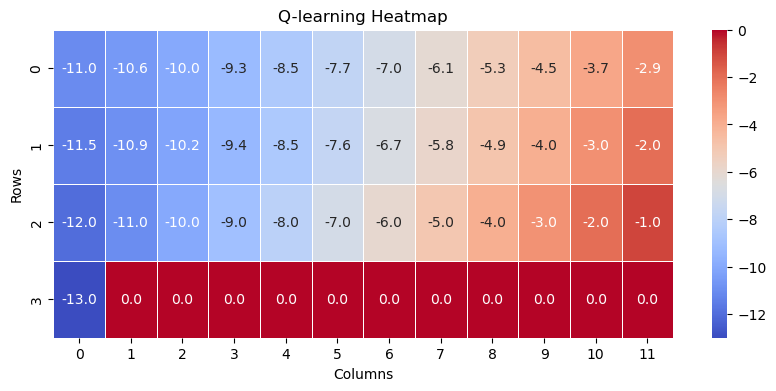

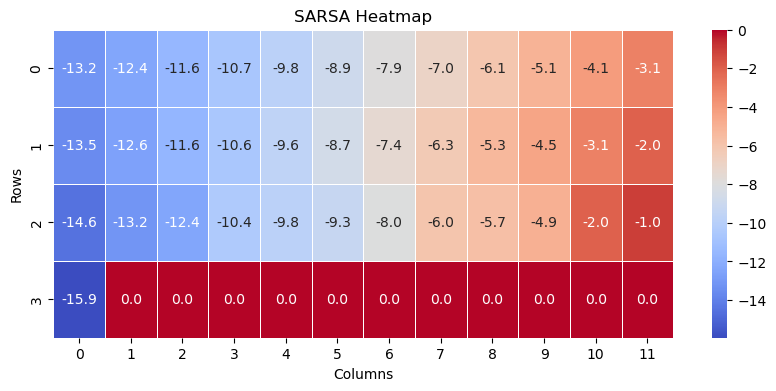

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_q_values(Q, title="Q-values Heatmap"):
    """
    Plots the Q-values of the environment as a heatmap.
    """
    q_values = np.max(Q, axis=1).reshape((4, 12))  # Take max Q-value per state
    plt.figure(figsize=(10, 4))
    sns.heatmap(q_values, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".1f")
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

# Plot Q-values for Q-learning and SARSA
plot_q_values(Q_qlearning, "Q-learning Heatmap")
plot_q_values(Q_sarsa, "SARSA Heatmap")


In [10]:
import time

def run_agent(Q, env, delay=0.5):
    """
    Runs the agent using the learned Q-table and renders each step.
    """
    state, _ = env.reset()  # Reset environment
    done = False
    env.render()  # Show initial state
    time.sleep(delay)
    
    while not done:
        action = np.argmax(Q[state])  # Choose best action
        state, _, done, _, _ = env.step(action)
        env.render()  # Show updated state
        time.sleep(delay)
    
    env.close()

# Run animation for Q-learning policy
print("Running Q-learning agent:")
run_agent(Q_qlearning, env)

# Run animation for SARSA policy
print("Running SARSA agent:")
run_agent(Q_sarsa, env)


Running Q-learning agent:


/home/zybu/.local/lib/python3.9/site-packages/gym/envs/toy_text/cliffwalking.py:167: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CliffWalking-v0", render_mode="rgb_array")
  logger.warn(


Running SARSA agent:
